Notebook for testing the trained models.

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import os
import pandas as pd
import torch.nn.functional as F

from lib.utils import get_free_gpu, load_lizard, debug
from lib.utils_vis import make_seed, to_rgb, damage_batch
from lib.EnergyCAModel import EnergyCAModel
from lib.CAModel import CAModel
from lib.utils import animate_steps
model_dir = 'models/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initialization

In [6]:

torch.backends.cudnn.benchmark = True # Speeds up stuff
torch.backends.cudnn.enabled = True

## General Parameters ##
global_params = {
    'CHANNEL_N': 16,
    'TARGET_PADDING': 16,
    'TARGET_SIZE': 40,
    'IMG_SIZE': 72,
    'MIN_STEPS': 64,
    'MAX_STEPS': 128,
}

## General Training Parameters ##
# choose cuda device with the least amount of current memory usage
training_params = {
    'lr': 2e-3,
    'lr_gamma': 0.9999,
    'betas': (0.5, 0.5),
    'n_epoch': 10000,
    'batch_size': 8,
    'grad_clip': 1.0,
    'device': torch.device('cuda:{}'.format(get_free_gpu(min_free_mem=0.8)) if torch.cuda.is_available() else 'cpu'),
    'history_save_dir': 'histories/',
    'model_save_dir': 'models/gumbel/', ###
}

ca_params = {"CELL_FIRE_RATE": 0.5}
number_of_batches = 10#10
beta_constFireRate_correspondance = {
    0: 0.958,
    1e-9: 0.634,
    5e-9: 0.634,
    2e-9: 0.471,
    5e-10: 0.278,
    2e-10: 0.689, ###
}


Getting free GPU...
| ID | GPU | MEM |
------------------
|  0 |  0% |  5% |
|  1 |  0% |  0% |
|  2 |  0% |  5% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
Using GPU:  0


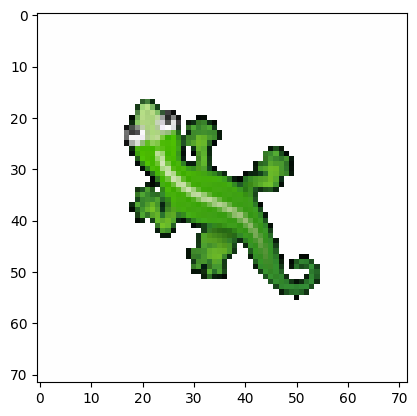

In [7]:
# Load target emoji
target_img = load_lizard('data/lizard_clean.png')
p = global_params['TARGET_PADDING']
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32))

# Create initial state
seed = make_seed((h, w), global_params['CHANNEL_N'])
x0 = np.repeat(seed[None, ...], training_params["batch_size"], 0)
x0 = torch.from_numpy(x0.astype(np.float32)).to(training_params['device'])

plt.imshow(to_rgb(pad_target.detach().cpu()[0]))

# Load csv

In [70]:
# load csvs from test_losses
all_files = [f for f in os.listdir('test_losses') if f.endswith('maxSteps128_epoch10000.csv')]
energyca_files = [f for f in all_files if f.startswith('EnergyCA')]
ca_files = [f for f in all_files if f.startswith('CA')]

ca_data = [
    {
        "loss": pd.read_csv(os.path.join('test_losses', f))['loss'].values,
        "loss_stderror": pd.read_csv(os.path.join('test_losses', f))['loss_stderror'].values,
        "constFireRate": float(f.split("constFireRate")[1].split('_')[0])
    }
    for f in ca_files if float(f.split("constFireRate")[1].split('_')[0]) in beta_constFireRate_correspondance.values()
]
energyca_data = [
    {
        "loss": pd.read_csv(os.path.join('test_losses', f))['loss'].values,
        "loss_stderror": pd.read_csv(os.path.join('test_losses', f))['loss_stderror'].values,
        "avg_fireRate":  pd.read_csv(os.path.join('test_losses', f))['avg_fireRate'].values,
        "betaEnergy": float(f.split("betaEnergy")[1].split('_')[0])
    }
    for f in energyca_files if float(f.split("betaEnergy")[1].split('_')[0]) in beta_constFireRate_correspondance.keys()
]

ca_data = sorted(ca_data, key=lambda x: x["constFireRate"])
energyca_data = sorted(energyca_data, key=lambda x: float(x["betaEnergy"]))

In [71]:
# Load histories
all_histories = [f for f in os.listdir('histories') if f.endswith('maxSteps128_history.csv')]
energyca_histories = [f for f in all_histories if f.startswith('EnergyCA')]
ca_histories = [f for f in all_histories if f.startswith('CA')]

ca_hist_data = [
    {
        "loss": pd.read_csv(os.path.join('histories', f))['loss'].values,
        "constFireRate": float(f.split("constFireRate")[1].split('_')[0])
    }
    for f in ca_histories if float(f.split("constFireRate")[1].split('_')[0]) in beta_constFireRate_correspondance.values()
]
energyca_hist_data = [
    {
        "loss": pd.read_csv(os.path.join('histories', f))['loss'].values,
        "loss_rec_val": pd.read_csv(os.path.join('histories', f))['loss_rec_val'].values,
        "loss_energy_val": pd.read_csv(os.path.join('histories', f))['loss_energy_val'].values,
        "betaEnergy": float(f.split("betaEnergy")[1].split('_')[0])
    }
    for f in energyca_histories if float(f.split("betaEnergy")[1].split('_')[0]) in beta_constFireRate_correspondance.keys()
]

energyca_hist_data = sorted(energyca_hist_data, key=lambda x: float(x['betaEnergy']))
ca_hist_data = sorted(ca_hist_data, key=lambda x: x['constFireRate'])


# Plots

## Training plots

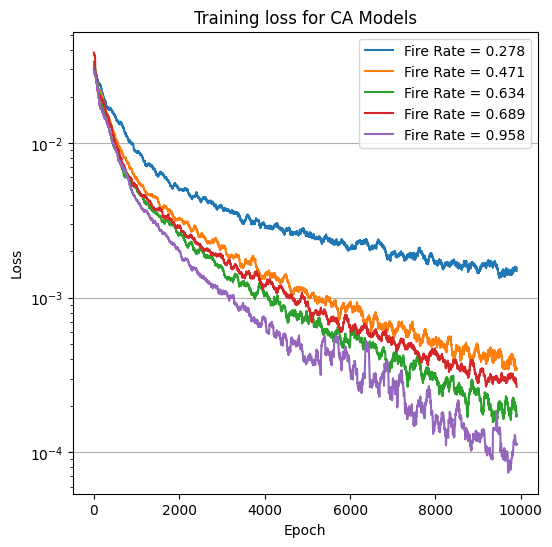

In [64]:
# plot ca loss history
plt.figure(figsize=(6,6))
# we'll use np.convolve to smooth the data
window_size = 100
filter = np.ones(window_size)/window_size

for data in ca_hist_data:
    plt.plot(np.convolve(data["loss"], filter, mode="valid"), label = "Fire Rate = {}".format(data['constFireRate']))

plt.title(f"Training loss for CA Models")
plt.legend()
plt.yscale('log')
plt.grid(axis='y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


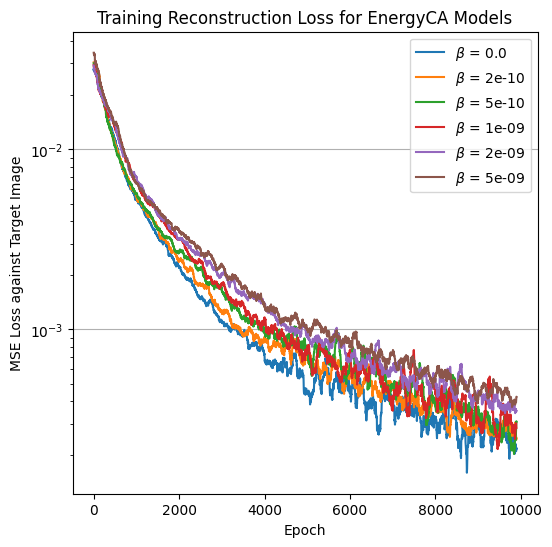

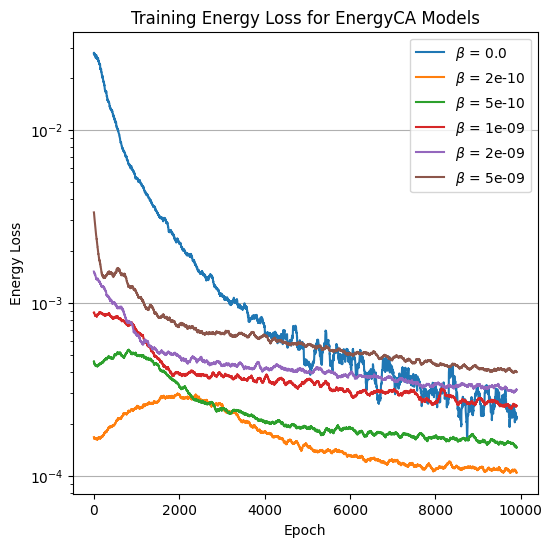

In [79]:
# plot energyca loss history, with loss_rec_val and loss_energy_val in different axes
window_size = 100
filter = np.ones(window_size)/window_size

# plot loss_rec_val
plt.figure(figsize=(6,6))
for data in energyca_hist_data:
    plt.plot(np.convolve(data["loss_rec_val"], filter, mode="valid"), label =r"$\beta$ = {}".format(data['betaEnergy']))

plt.title(f"Training Reconstruction Loss for EnergyCA Models")
plt.legend()
plt.yscale('log')
plt.grid(axis='y')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss against Target Image")
plt.show()

# plot loss_energy_val
plt.figure(figsize=(6,6))
for data in energyca_hist_data:
    plt.plot(np.convolve(data["loss_energy_val"], filter, mode="valid"), label =r"$\beta$ = {}".format(data['betaEnergy']))

plt.title(f"Training Energy Loss for EnergyCA Models")
plt.legend()
plt.yscale('log')
plt.grid(axis='y')
plt.xlabel("Epoch")
plt.ylabel("Energy Loss")
plt.show()

## EnergyCA persistance plots

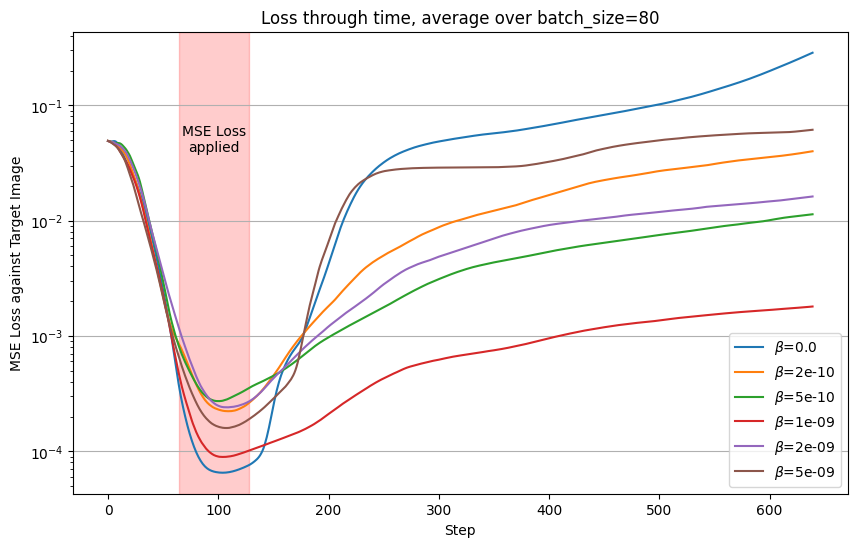

In [113]:
plt.figure(figsize=(10,6))
for data in energyca_data:
    plt.plot(data["loss"], label=r"$\beta$={}".format(data["betaEnergy"]))
    #plt.fill_between(np.arange(len(data["loss"])), data["loss"]-data["loss_stderror"], data["loss"]+data["loss_stderror"], alpha=0.2)

# add a colored band between x = global_params["MIN_STEPS"] and x = global_params["MAX_STEPS"]
plt.axvspan(global_params["MIN_STEPS"], global_params["MAX_STEPS"], alpha=0.2, color='red')
plt.text(96, 4e-2, "MSE Loss\napplied", fontsize=10, horizontalalignment='center')


plt.legend()
plt.title(f"Loss through time, average over batch_size={number_of_batches*training_params['batch_size']}")
plt.yscale('log')
plt.ylabel("MSE Loss against Target Image")
plt.xlabel("Step")
plt.grid(axis='y')
#plt.ylim([0,0.1])
plt.show()

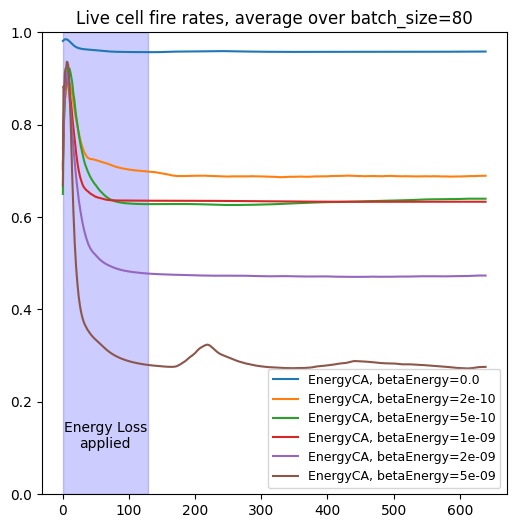

In [120]:
# plot average fire rate
plt.figure(figsize=(6,6))

for data in energyca_data:
    plt.plot(data["avg_fireRate"], label="EnergyCA, betaEnergy={}".format(data["betaEnergy"]))
    
plt.axvspan(0, global_params["MAX_STEPS"], alpha=0.2, color='blue')
plt.text(64, 0.1, "Energy Loss\napplied", fontsize=10, horizontalalignment='center')

plt.legend(fontsize=9)
plt.title(f"Live cell fire rates, average over batch_size={number_of_batches*training_params['batch_size']}")
plt.ylim([0,1])
plt.show()

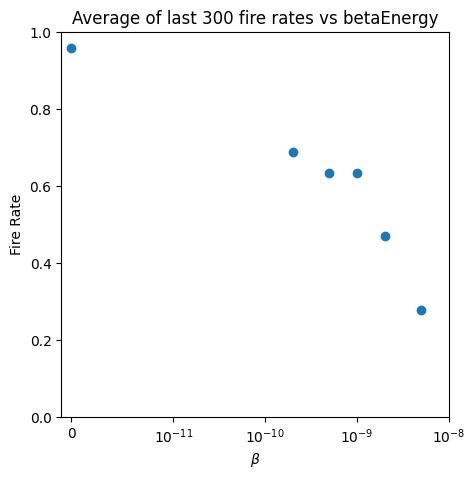

In [38]:
# plot betaEnergy values vs average of last 300 fireRates
last_fireRates = [data["avg_fireRate"][-300:].mean() for data in energyca_data]
plt.figure(figsize=(5,5))
plt.scatter([data["betaEnergy"] for data in energyca_data], last_fireRates)
plt.title(f"Average of last 300 fire rates vs betaEnergy")
plt.xlabel(r"$\beta$")
plt.xticks([0,1e-11,1e-10,1e-9,1e-8])
plt.xlim([-1e-12,1e-8])
plt.ylim([0,1])
plt.xscale('symlog', linthresh = 1e-11)
plt.ylabel("Fire Rate")
plt.show()

## Normal model persistence plots

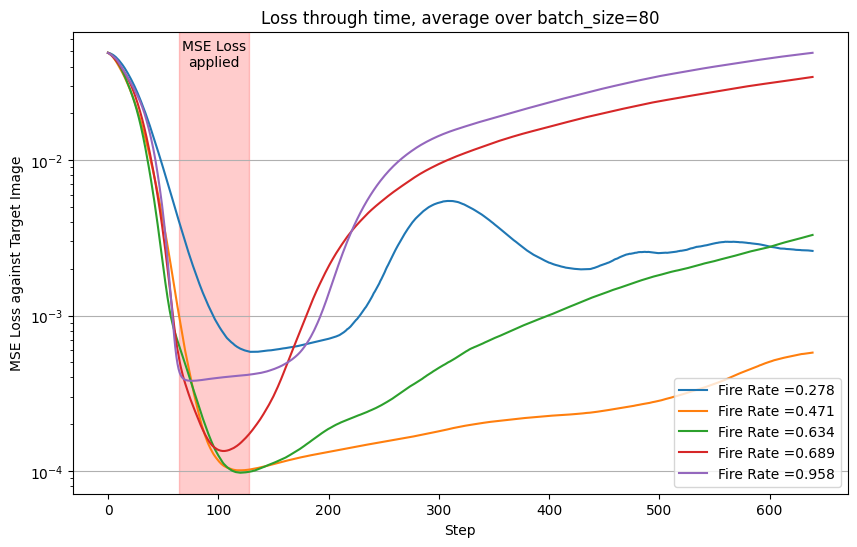

In [122]:
plt.figure(figsize=(10,6))
for data in ca_data:
    plt.plot(data["loss"], label="Fire Rate ={}".format(data["constFireRate"]))
    #plt.fill_between(np.arange(len(data["loss"])), data["loss"]-data["loss_stderror"], data["loss"]+data["loss_stderror"], alpha=0.2)
plt.axvspan(global_params["MIN_STEPS"], global_params["MAX_STEPS"], alpha=0.2, color='red')
plt.text(96, 4e-2, "MSE Loss\napplied", fontsize=10, horizontalalignment='center')

plt.legend()
plt.title(f"Loss through time, average over batch_size={number_of_batches*training_params['batch_size']}")
plt.yscale('log')
plt.ylabel("MSE Loss against Target Image")
plt.xlabel("Step")
plt.grid(axis='y')
#plt.ylim([0,0.1])
plt.show()

## CA vs EnergyCA comparison plots

/tmp/ipykernel_3105182/4218927853.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3, i+1, sharey=plt.subplot(2,3, 1), sharex = plt.subplot(2,3, 4))


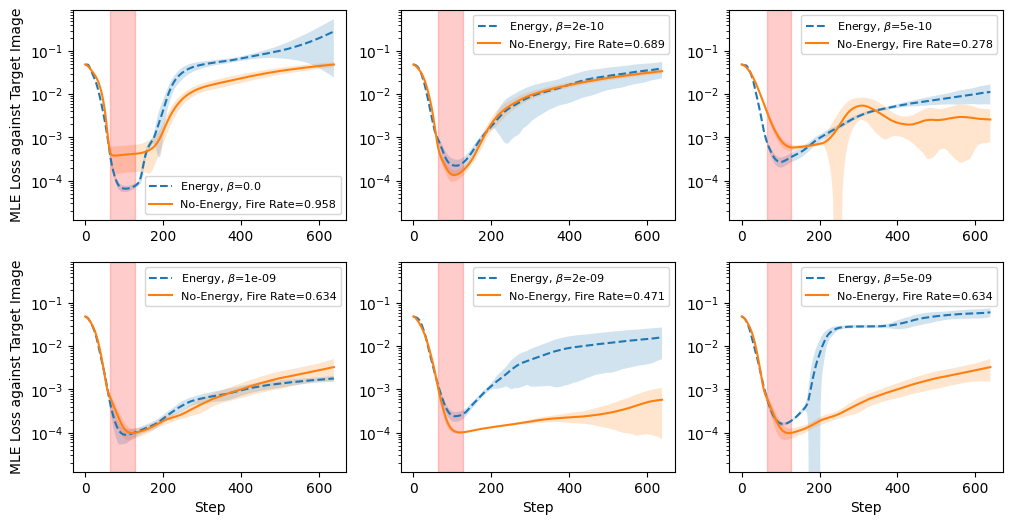

In [123]:
# for each betaEnergy, plot it's loss in the same plot as the loss of the corresponding constFireRate

plt.figure(figsize=(12,6))
for i, data in enumerate(energyca_data):
    # share y axis in subplots in same row, and share x axis in subplots in same column
    plt.subplot(2,3, i+1, sharey=plt.subplot(2,3, 1), sharex = plt.subplot(2,3, 4))

    # find corresponding ca_data
    data_ca = [data_ca for data_ca in ca_data if data_ca['constFireRate'] == beta_constFireRate_correspondance[data['betaEnergy']]][0]

    #plot in same axis
    plt.plot(data['loss'],'--', label=r"Energy, $\beta$={}".format(data['betaEnergy']))
    plt.fill_between(np.arange(len(data['loss'])), data['loss']-data['loss_stderror'], data['loss']+data['loss_stderror'], alpha=0.2)
    plt.plot(data_ca['loss'],'-', label="No-Energy, Fire Rate={}".format(data_ca['constFireRate']))
    plt.fill_between(np.arange(len(data_ca['loss'])), data_ca['loss']-data_ca['loss_stderror'], data_ca['loss']+data_ca['loss_stderror'], alpha=0.2)

    plt.axvspan(global_params["MIN_STEPS"], global_params["MAX_STEPS"], alpha=0.2, color='red')

    if i in [0,3]:
        plt.ylabel("MLE Loss against Target Image")
    if i in [3,4,5]:
        plt.xlabel('Step')

    plt.yscale('log')
    plt.legend(fontsize=8)

**Missing plots**

Persistence:
 - For best model: Lizard evolution images (CA vs EnergyCA), show fireRates of both

Damage resistance (for best model):
- Lizard evolution images (CA vs EnergyCA), show fireRates of both. Do for head, center and leg.
- Loss evolution after damage (CA vs EnergyCA), show fireRates of both. Do for head, center and leg.

## Load gumbel test model

In [ ]:
# Load model
max_steps = global_params['MAX_STEPS']*5
beta_energy = 1e-9
model_name = model_dir + f'gumbel_maxSteps{global_params["MAX_STEPS"]}/EnergyCA_gumbel_EnergyLoss_betaEnergy{beta_energy:.0e}_maxSteps{global_params["MAX_STEPS"]}_epoch{training_params["n_epoch"]}.pth'
model = EnergyCAModel(global_params["CHANNEL_N"], training_params["device"])
model.load_state_dict(torch.load(model_name))
model.eval()


EnergyCAModel(
  (fc0): Linear(in_features=48, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=16, bias=False)
  (fireRate_layer): Linear(in_features=128, out_features=1, bias=True)
)

x_steps.shape = torch.Size([640, 8, 72, 72, 16])


/tmp/ipykernel_372774/2347808157.py:12: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([8, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  losses = [torch.mean(F.mse_loss(x_steps[k,:,:,:,:4], pad_target)).item() for k in range(max_steps)]


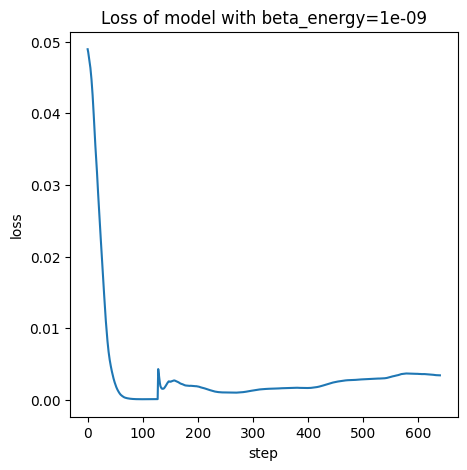

In [ ]:
# Run the model
with torch.no_grad():
    x_steps, fireRates_steps, update_grid_steps = model(x0, steps=max_steps, 
                                    damage_at_step=global_params["MAX_STEPS"], damage_location='center', damaged_in_batch=training_params["batch_size"],
                                    get_update_grid = True)

# compute the loss (mean accross the batch)
x_steps = x_steps.detach().cpu()
fireRates_steps = fireRates_steps.detach().cpu()
update_grid_steps = update_grid_steps.detach().cpu()
debug("x_steps.shape")
losses = [torch.mean(F.mse_loss(x_steps[k,:,:,:,:4], pad_target)).item() for k in range(max_steps)]

# plot the loss
plt.figure(figsize=(5, 5))
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss')
plt.title(f'Loss of model with beta_energy={beta_energy:.0e}')
plt.show()

In [13]:
debug("update_grid_steps.shape")

update_grid_steps.shape = torch.Size([640, 8, 72, 72])


In [14]:
# animate
animate_steps(
    to_rgb(x_steps),
    fireRates_steps,
    update_grid_steps,
)

# Persistance Test

## Gumbel models persistance test

In [8]:
# Load all models
max_steps = global_params["MAX_STEPS"]*5
gumbel_dir = model_dir + f'gumbel_maxSteps{global_params["MAX_STEPS"]}/'
model_names = os.listdir(gumbel_dir)
model_names = [m for m in model_names if m.endswith('.pth')]
gumbel_models = [{} for _ in model_names]
param = 'betaEnergy'
beta_constFireRate_correspondance = {
    0: 0.958,
    1e-9: 0.634,
    5e-9: 0.634,
    2e-9: 0.471,
    5e-10: 0.278,
    2e-10: 0.689, ###
}
for i,model in enumerate(gumbel_models):
    model['name'] = model_names[i]
    model[param] = float(model['name'].split(param)[1].split('_')[0])
    model['constFireRate'] = beta_constFireRate_correspondance[model['betaEnergy']]
    model['model'] = EnergyCAModel(global_params["CHANNEL_N"], training_params["device"])
    model['model'].load_state_dict(torch.load(os.path.join(gumbel_dir, model['name'])))
    model['model'].name = model['name']
    model['model'].eval()

print("Loaded {} models from {}".format(len(gumbel_models), gumbel_dir))
print("betaEnergies: {}".format([m['betaEnergy'] for m in gumbel_models]))

Loaded 6 models from models/gumbel_maxSteps128/
betaEnergies: [0.0, 1e-09, 2e-09, 5e-09, 2e-10, 5e-10]


In [9]:
# Run the models
# Repeat number_of_batches times, to get better statistics

for m, model in enumerate(gumbel_models):
    x_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:])
    fireRates_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:3])
    update_grid_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:3])
    for i in range(number_of_batches):
        # clean previous print and replace with new one
        print(" "*100, end='\r')
        print(f"Running model {model['name']} batch {i+1}/{number_of_batches}", end='\r')
        with torch.no_grad():
            x_steps, fireRates_steps = model['model'](x0, steps=max_steps)

        x_steps_batch[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = x_steps.detach().cpu()
        fireRates_steps_batch[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = fireRates_steps.detach().cpu()
    model['x_steps'] = x_steps_batch
    model['fireRates_steps'] = fireRates_steps_batch
        

In [10]:

# Plot losses of all models through time, averaging over the batch
for i,model in enumerate(gumbel_models):
    model['loss'] = [F.mse_loss(model['x_steps'][k,:,:,:,:4], pad_target).item() for k in range(max_steps)]
    # compute average fireRate only for live cells (channel 3 > 0.1)
    model['avg_fireRate'] = [torch.mean(model['fireRates_steps'][k,:,:,:][model['x_steps'][k,:,:,:,3] > 0.1]).item() for k in range(max_steps)]
    model['loss_stderror'] = [F.mse_loss(model['x_steps'][k,:,:,:,:4], pad_target, reduction='none').mean(dim=[1,2,3]).std().item() for k in range(max_steps)]
    model['loss'] = np.array(model['loss'])
    model['avg_fireRate'] = np.array(model['avg_fireRate'])
    model['loss_stderror'] = np.array(model['loss_stderror'])
    


/tmp/ipykernel_3105182/2255369537.py:3: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  model['loss'] = [F.mse_loss(model['x_steps'][k,:,:,:,:4], pad_target).item() for k in range(max_steps)]
/tmp/ipykernel_3105182/2255369537.py:6: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  model['loss_stderror'] = [F.mse_loss(model['x_steps'][k,:,:,:,:4], pad_target, reduction='none').mean(dim=[1,2,3]).std().item() for k in range(max_steps)]


In [14]:
model['loss_stderror'].shape

(640,)

In [16]:
# Save each loss to a .csv file, each file will have the name of the model.
# The 1st column is named "step" and the 2nd column is named "loss"

for model in gumbel_models:
    df = pd.DataFrame({'step': list(range(max_steps)), 'loss': model["loss"], 'loss_stderror': model["loss_stderror"], 'avg_fireRate':model["avg_fireRate"]})
    df.to_csv(os.path.join('test_losses',  model['name'].replace('.pth', '.csv')), index=False)

## Plots

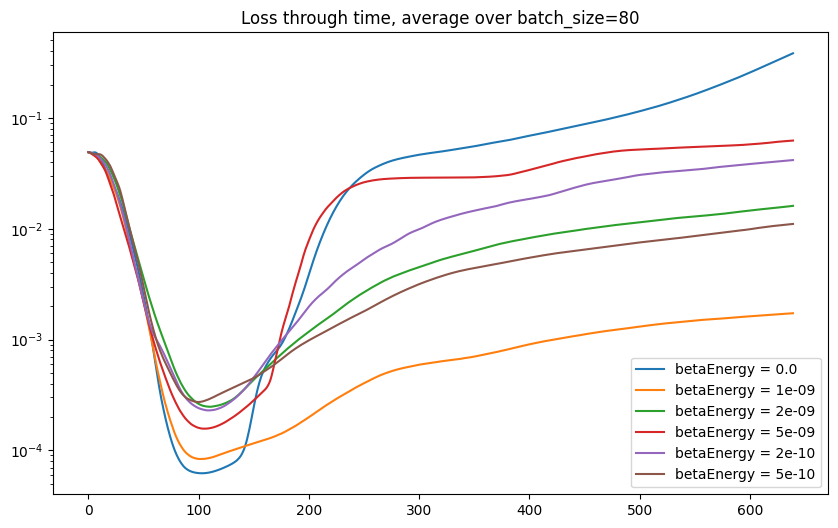

In [8]:
# plot the losses. All the plots in same axes, and each plot should have a label with the params used to train the model
plt.figure(figsize=(10,6))
for model in gumbel_models:
    plt.plot(model['loss'], label="betaEnergy = {}".format(model['betaEnergy']))
    
plt.legend()
plt.title(f"Loss through time, average over batch_size={number_of_batches*training_params['batch_size']}")
#plt.ylim([0.0,0.06])
plt.yscale('log')
plt.show()



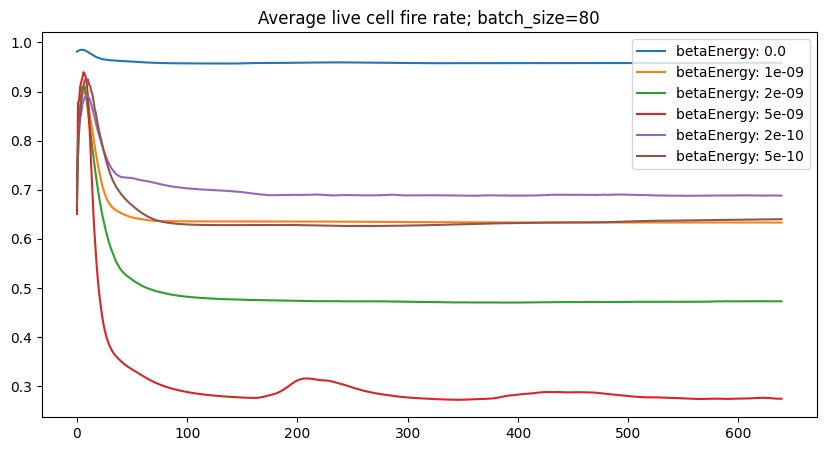

In [9]:
# plot the mean updates. All the plots in same axes, and each plot should have a label with the params used to train the model
plt.figure(figsize=(10,5))
for model in gumbel_models:
    plt.plot(model['avg_fireRate'], label="betaEnergy: {}".format(model['betaEnergy']))
    
plt.legend()
plt.title(f"Average live cell fire rate; batch_size={number_of_batches*training_params['batch_size']}")
#plt.ylim([0.0,0.06])
#plt.yscale('log')
plt.show()



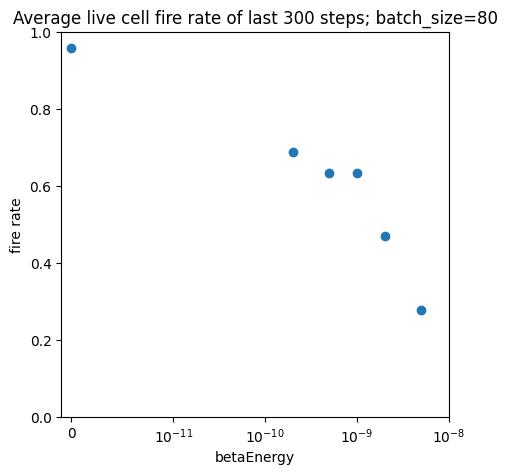

In [18]:
# plot the average firerate of the last 300 steps vs the beta energy
avg_fireRates_last = [np.mean(model['avg_fireRate'][-300:]) for model in gumbel_models]
plt.figure(figsize=(5,5))

plt.plot([model['betaEnergy'] for model in gumbel_models], avg_fireRates_last, 'o')
plt.title(f"Average live cell fire rate of last 300 steps; batch_size={number_of_batches*training_params['batch_size']}")
plt.xlabel("betaEnergy")
plt.ylabel("fire rate")
plt.xticks([0,1e-11,1e-10,1e-9,1e-8])
plt.xlim([-1e-12,1e-8])
plt.ylim([0,1])
plt.xscale('symlog', linthresh=1e-11)
plt.show()

In [19]:
print("Avg final fire rate of all models:")
for model in gumbel_models:
    print("betaEnergy: {}, avg fire rate: {:.3f}".format(model['betaEnergy'], np.mean(model['avg_fireRate'][-300:])))

Avg final fire rate of all models:
betaEnergy: 0.0, avg fire rate: 0.958
betaEnergy: 1e-09, avg fire rate: 0.633
betaEnergy: 2e-09, avg fire rate: 0.472
betaEnergy: 5e-09, avg fire rate: 0.279
betaEnergy: 2e-10, avg fire rate: 0.689
betaEnergy: 5e-10, avg fire rate: 0.635


Text(0.5, 0.98, 'Batch index = 7')

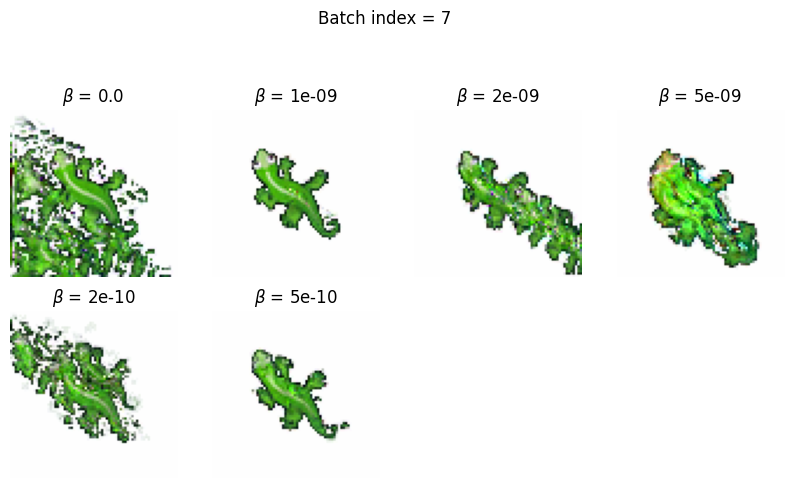

In [20]:
# Visualize a final state for each model in a grid
# Each model should have a label with the params used to train the model

# get the final state for each model
batch_i = np.random.randint(number_of_batches*training_params["batch_size"])

# plot the final state for each model
plt.figure(figsize=(10, 10))
for i,model in enumerate(gumbel_models):
    plt.subplot(4, 4, i+1)
    plt.imshow(to_rgb(model['x_steps'][-1,batch_i]))
    plt.title(rf"$\beta$ = {model['betaEnergy']}")
    plt.axis('off')

plt.suptitle("Batch index = {}".format(batch_i))



## Normal CA models persistence test

In [5]:
# Load all CA models
max_steps = global_params["MAX_STEPS"]*5
no_gumbel_dir = model_dir + f'no_gumbel_maxSteps{global_params["MAX_STEPS"]}/'
model_names = os.listdir(no_gumbel_dir)
param = 'constFireRate'
param_vals = [0.958, 0.634, 0.471, 0.278, 0.689] #values correspondent with final fireRates of EnergyCA models
model_names = [m for m in model_names if m.endswith('.pth') if float(m.split(param)[1].split('_')[0]) in param_vals]

models = [{} for i in range(len(param_vals))]

for i,model in enumerate(models):
    model['name'] = model_names[i]
    model[param] = float(model["name"].split(param)[1].split('_')[0])
    model['model'] = CAModel(global_params["CHANNEL_N"], fire_rate = model[param], device = training_params["device"])
    model['model'].load_state_dict(torch.load(os.path.join(no_gumbel_dir, model['name'])))
    model['model'].name = model['name']
    model['model'].eval()

print("Loaded {} models from {}".format(len(models), no_gumbel_dir))
print("constFireRates: {}".format([model[param] for model in models]))
                   

Loaded 5 models from models/no_gumbel_maxSteps128/
constFireRates: [0.634, 0.278, 0.471, 0.958, 0.689]


In [6]:
# Run model for max_steps
for model in models:
    x_steps_total = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:])

    for i in range(number_of_batches): 
        print(f"Running model {model['name']} for batch {i+1:02d}/{number_of_batches}", end='\r')

        x_steps = []
        update_grid_steps = []
        for j in range(max_steps):
            if j==0:
                x = x0
            with torch.no_grad():
                x = model['model'](x, steps=1)
            x_steps.append(x.detach().cpu())
        x_steps = torch.stack(x_steps)
        x_steps_total[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = x_steps

    model["x_steps"] = x_steps_total

debug("models[0]['x_steps'].shape")



models[0]['x_steps'].shape = torch.Size([640, 80, 72, 72, 16])pth for batch 10/10


In [7]:

# compute the loss (mean accross the batch) for each model
for model in models:
    model["loss"] = [F.mse_loss(model["x_steps"][k,:,:,:,:4], pad_target).item() for k in range(max_steps)]
    model["loss_stderror"] = [F.mse_loss(model["x_steps"][k,:,:,:,:4], pad_target, reduction='none').mean(dim=[1,2,3]).std().item() for k in range(max_steps)]
    model["loss"] = np.array(model["loss"])
    model["loss_stderror"] = np.array(model["loss_stderror"])



/tmp/ipykernel_3095492/1337932119.py:3: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  model["loss"] = [F.mse_loss(model["x_steps"][k,:,:,:,:4], pad_target).item() for k in range(max_steps)]
/tmp/ipykernel_3095492/1337932119.py:4: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  model["loss_stderror"] = [F.mse_loss(model["x_steps"][k,:,:,:,:4], pad_target, reduction='none').mean(dim=[1,2,3]).std().item() for k in range(max_steps)]


In [8]:
# save loss to csv, 1st column is the step, 2nd column is the loss, the file name has the model name
for model in models:
    df = pd.DataFrame({'step': list(range(max_steps)), 'loss': model["loss"], 'loss_stderror': model["loss_stderror"]})
    df.to_csv(os.path.join('test_losses',  model['name'].replace('.pth', '.csv')), index=False)

In [ ]:
# plot the loss for each
plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(model["loss"], label=f"fire rate = {model['constFireRate']}")
    plt.fill_between(range(max_steps), model["loss"]-model["loss_stderror"], model["loss"]+model["loss_stderror"], alpha=0.2)
plt.xlabel('step')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.title('Loss of CA models')
plt.show()

Text(0.5, 0.98, 'Batch index = 0')

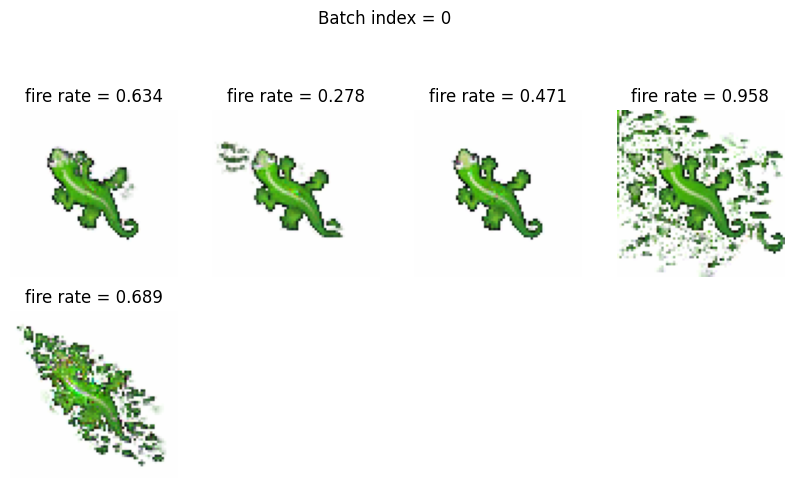

In [15]:
# visualize last state for each model
batch_i = 0
plt.figure(figsize=(10, 10))
for i, model in enumerate(models):
    plt.subplot(4, 4, i+1)
    plt.imshow(to_rgb(model["x_steps"][-1,batch_i,:,:,:]))
    plt.title(f"fire rate = {model['constFireRate']}")
    plt.axis('off')

plt.suptitle("Batch index = {}".format(batch_i))

In [ ]:
# show animation
animate_steps(
    to_rgb(x_steps),
    num_cols=1,
)


['EnergyCA_gumbel_EnergyLoss_betaEnergy0e+00_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy1e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy2e-09_maxSteps128_epoch10000.csv', 'CA_constFireRate7.50e-01_maxSteps128_epoch10000.csv', 'CA_constFireRate2.50e-01_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy5e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy2e-10_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy5e-10_maxSteps128_epoch10000.csv', 'CA_constFireRate5e-01_maxSteps128_epoch10000.csv', 'CA_constFireRate6.34e-01_maxSteps128_epoch10000.csv', 'CA_constFireRate1.00e+00_maxSteps128_epoch10000.csv', 'CA_constFireRate2.78e-01_maxSteps128_epoch10000.csv', 'CA_constFireRate4.71e-01_maxSteps128_epoch10000.csv', 'CA_constFireRate9.58e-01_maxSteps128_epoch10000.csv', 'CA_constFireRate6.89e-01_maxSteps128_epoch10000.csv']


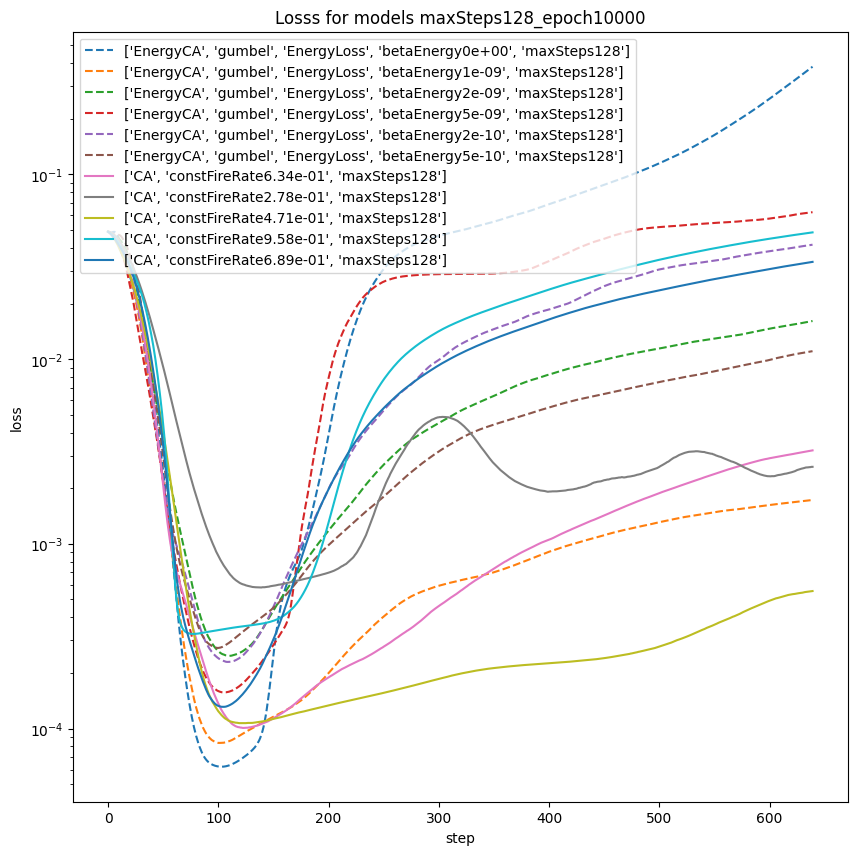

In [19]:
# Plot in the same axis as all the .csv files in the /test_losses folder.
# The 1st column of each csv file is the step, the 2nd column is the loss, but the columns are not named in the file.
file_ending = f'maxSteps{global_params["MAX_STEPS"]}_epoch{training_params["n_epoch"]}.csv'
file_names = [t for t in os.listdir('test_losses') if t.endswith(file_ending)]
print(file_names)
test_losses = [pd.read_csv(os.path.join('test_losses', t)) for t in file_names]
param_vals = [0.958, 0.634, 0.471, 0.278, 0.689] #values correspondent with final fireRates of EnergyCA models

# plot the test losses
plt.figure(figsize=(10,10))
for i, t in enumerate(test_losses):
    if 'EnergyCA' in file_names[i]:
        plt.plot(t['step'], t['loss'],'--', label=file_names[i].split('_')[:-1])
    elif float(file_names[i].split(param)[1].split('_')[0]) in param_vals:
        plt.plot(t['step'], t['loss'],'-', label=file_names[i].split('_')[:-1])
plt.xlabel('step')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Losss for models ' + file_ending.split('.')[0])
plt.legend()
plt.show()



# Comparison plots

/tmp/ipykernel_2767586/1305647099.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3, i+1, sharey=plt.subplot(2,3, 1), sharex = plt.subplot(2,3, 4))
/tmp/ipykernel_2767586/1305647099.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3, i+1, sharey=plt.subplot(2,3, 1), sharex = plt.subplot(2,3, 4))


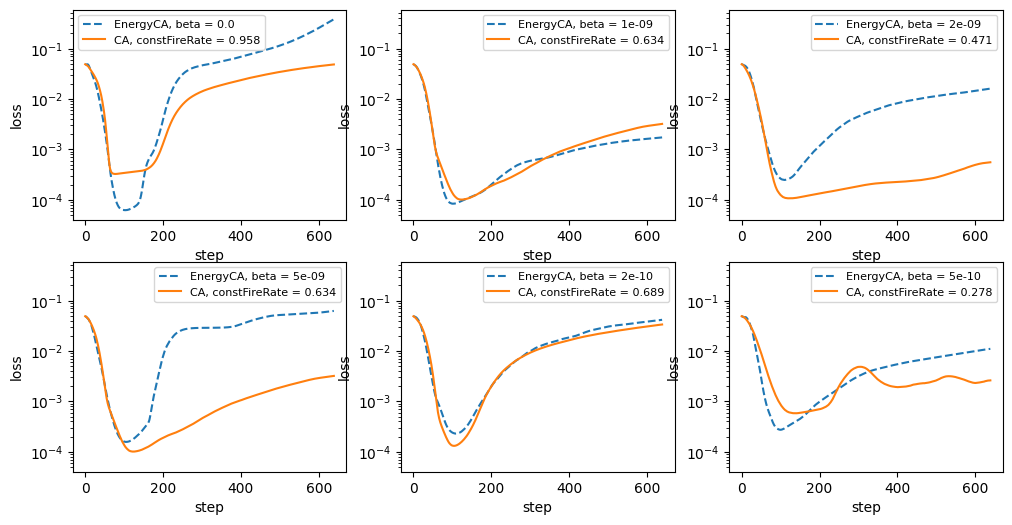

In [43]:
beta_constFireRate_correspondance = {
    0: 0.958,
    1e-9: 0.634,
    5e-9: 0.634,
    2e-9: 0.471,
    5e-10: 0.278,
    2e-10: 0.689,
}
file_ending = f'maxSteps{global_params["MAX_STEPS"]}_epoch{training_params["n_epoch"]}.csv'
file_names = [t for t in os.listdir('test_losses') if t.endswith(file_ending)]
# list of dicts with keys: "file" and "param"
energyca_files = [{'file': t, 'betaEnergy': float(t.split('betaEnergy')[1].split('_')[0])} for t in file_names if 'EnergyCA' in t]
ca_files = [{'file': t, 'constFireRate': float(t.split('constFireRate')[1].split('_')[0])} for t in file_names if 'EnergyCA' not in t if float(t.split(param)[1].split('_')[0]) in beta_constFireRate_correspondance.values()]

# plot the test losses in separate axis, each plot is a different beta with the correspondending constFireRate
plt.figure(figsize=(12,6))
for i, t in enumerate(energyca_files):
    # share y axis in subplots in same row, and share x axis in subplots in same column
    plt.subplot(2,3, i+1, sharey=plt.subplot(2,3, 1), sharex = plt.subplot(2,3, 4))

    # find corresponding constFireRate
    constFireRate = beta_constFireRate_correspondance[t['betaEnergy']]
    ca_file = [f for f in ca_files if f['constFireRate'] == constFireRate][0]

    energyca_df = pd.read_csv(os.path.join('test_losses', t['file']))
    ca_df = pd.read_csv(os.path.join('test_losses', ca_file['file']))

    #plot in same axis
    plt.plot(energyca_df['step'], energyca_df['loss'],'--', label="EnergyCA, beta = {}".format(t['betaEnergy']))
    plt.plot(ca_df['step'], ca_df['loss'],'-', label="CA, constFireRate = {}".format(ca_file['constFireRate']))
    plt.xlabel('step')
    # plt.ylabel('loss')
    plt.yscale('log')
    plt.legend(fontsize=8)




# Damage resistance

## Gumbel models

In [68]:
# Load all models
max_steps = global_params["MAX_STEPS"]*2
gumbel_dir = model_dir + f'gumbel_maxSteps{global_params["MAX_STEPS"]}/'
model_names = os.listdir(gumbel_dir)
model_names = [m for m in model_names if m.endswith('.pth')]
models = []
for m in model_names:
    model = EnergyCAModel(global_params["CHANNEL_N"], training_params["device"])
    model.load_state_dict(torch.load(os.path.join(gumbel_dir, m)))
    model.eval()
    models.append(model)

print("Loaded {} models from {}".format(len(models), gumbel_dir))

# Damage params
damage_at_step= global_params["MAX_STEPS"]
damage_location='tail' #['random', 'center', 'head', 'leg1', 'tail'] 
damaged_in_batch= training_params["batch_size"]
                   

Loaded 8 models from models/gumbel_maxSteps128/


In [69]:
# get model params
params = {
    'betaEnergy': [],
}

for m in model_names:
    for param in params:
        params[param].append(float(m.split(param)[1].split('_')[0]))

debug("params")

params = {'betaEnergy': [0.0, 1e-09, 2e-09, 3e-09, 4e-09, 5e-09, 2e-10, 5e-10]}


In [70]:
# Run the models
# Repeat number_of_batches times, to get better statistics
x_steps_models = []
fireRates_steps_models = []
for m, model in enumerate(models):
    x_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:])
    fireRates_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:3])
    
    for i in range(number_of_batches):
        # clean previous print and replace with new one
        print(" "*100, end='\r')
        print(f"Running model {model_names[m]} batch {i+1}/{number_of_batches}", end='\r')
        with torch.no_grad():
            x_steps, fireRates_steps = model(x0, steps=max_steps,
                                             damage_at_step=damage_at_step, damage_location=damage_location, 
                                             damaged_in_batch=damaged_in_batch)

        x_steps_batch[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = x_steps.detach().cpu()
        fireRates_steps_batch[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = fireRates_steps.detach().cpu()
    
    x_steps_models.append(x_steps_batch)
    fireRates_steps_models.append(fireRates_steps_batch)

        

In [71]:
debug("x_steps.shape")
debug("fireRates_steps.shape")
debug("len(x_steps_models)")
debug("x_steps_models[0].shape")

x_steps.shape = torch.Size([256, 8, 72, 72, 16])
fireRates_steps.shape = torch.Size([256, 8, 72, 72])
len(x_steps_models) = 8
x_steps_models[0].shape = torch.Size([256, 80, 72, 72, 16])


In [72]:

# Plot losses of all models through time, averaging over the batch
losses_models = []
for x_steps in x_steps_models:
    loss = [F.mse_loss(x_steps[k,:,:,:,:4], pad_target).item() for k in range(max_steps)]
    losses_models.append(loss)


/tmp/ipykernel_300876/653198729.py:4: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = [F.mse_loss(x_steps[k,:,:,:,:4], pad_target).item() for k in range(max_steps)]


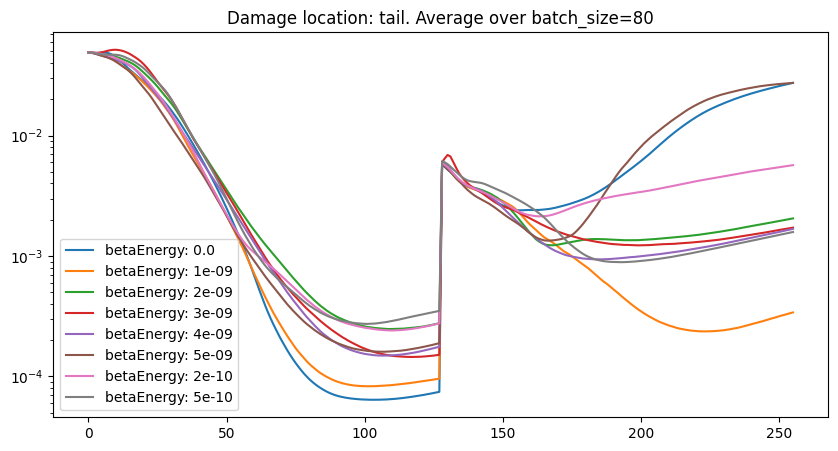

In [73]:
# plot the losses. All the plots in same axes, and each plot should have a label with the params used to train the model
plt.figure(figsize=(10,5))
for i, l in enumerate(losses_models):
    plt.plot(l, label="betaEnergy: {}".format(params['betaEnergy'][i]))
    
plt.legend()
plt.title(f"Damage location: {damage_location}. Average over batch_size={number_of_batches*training_params['batch_size']}")
#plt.ylim([0.0,0.06])
plt.yscale('log')
plt.show()



Text(0.5, 0.98, 'Damage location: tail; Batch index = 31')

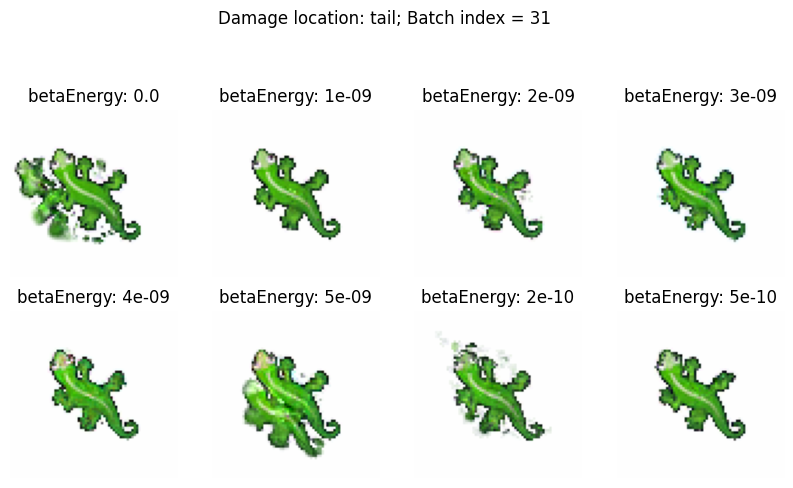

In [74]:
# Visualize a final state for each model in a grid
# Each model should have a label with the params used to train the model

# get the final state for each model
batch_i = np.random.randint(number_of_batches*training_params["batch_size"])
x_final_models = [x_steps_models[i][-1,batch_i,:,:,:] for i in range(len(x_steps_models))]
x_final_models = torch.stack(x_final_models)

# plot the final state for each model
plt.figure(figsize=(10, 10))
for i in range(x_final_models.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(to_rgb(x_final_models[i]))
    plt.title(f"betaEnergy: {params['betaEnergy'][i]}")
    plt.axis('off')

plt.suptitle("Damage location: {}; Batch index = {}".format(damage_location, batch_i))



In [75]:
# Save each loss to a .csv file, each file will have the name of the model.
# The 1st column is named "step" and the 2nd column is named "loss"

for i, l in enumerate(losses_models):
    df = pd.DataFrame({'step': list(range(max_steps)), 'loss': l})
    df.to_csv(os.path.join(f'damage_losses/{damage_location}/', model_names[i].split('.')[0] + '.csv'), index=False)

## Normal CA model (for damage)

In [46]:
# Load CA model
max_steps = global_params["MAX_STEPS"]*2
no_gumbel_dir = model_dir + f'no_gumbel_maxSteps{global_params["MAX_STEPS"]}/'
model_name = f'CA_constFireRate{ca_params["CELL_FIRE_RATE"]:.0e}_maxSteps{global_params["MAX_STEPS"]}_epoch{training_params["n_epoch"]}.pth'
model = CAModel(global_params["CHANNEL_N"], ca_params['CELL_FIRE_RATE'], training_params["device"])
model.load_state_dict(torch.load(no_gumbel_dir + model_name))
model.eval()

# Damage params
damage_at_step= global_params["MAX_STEPS"]
damage_location='tail' #['random', 'center', 'head', 'leg1', 'tail'] 
damaged_in_batch= training_params["batch_size"]

x_steps_total.shape = torch.Size([256, 80, 72, 72, 16])


/tmp/ipykernel_300876/4030091241.py:21: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ca_losses = [F.mse_loss(x_steps_total[k,:,:,:,:4], pad_target).item() for k in range(max_steps)]


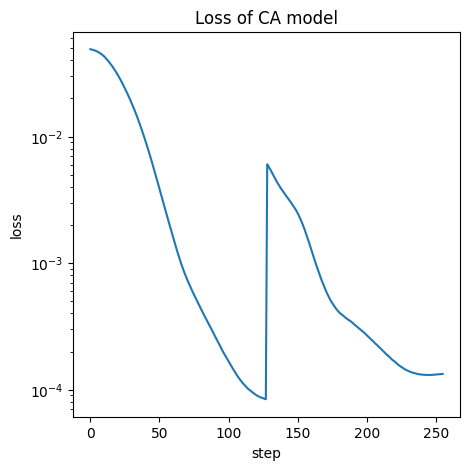

In [47]:
# Run model for max_steps
x_steps_total = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:])
for i in range(number_of_batches): 
    x_steps = []
    for j in range(max_steps):
        if j==0:
            x = x0
        if j==damage_at_step:
            x = damage_batch(x, 
                            training_params["device"],
                            img_size = 72, 
                            damage_location = damage_location, damaged_in_batch = damaged_in_batch)
        with torch.no_grad():
            x = model(x, steps=1)
        x_steps.append(x.detach().cpu())
    x_steps = torch.stack(x_steps)
    x_steps_total[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = x_steps

debug("x_steps_total.shape")
# compute the loss (mean accross the batch)
ca_losses = [F.mse_loss(x_steps_total[k,:,:,:,:4], pad_target).item() for k in range(max_steps)]

# plot the loss
plt.figure(figsize=(5, 5))
plt.plot(ca_losses)
plt.xlabel('step')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Loss of CA model')
plt.show()

In [48]:
# show animation
animate_steps(
    to_rgb(x_steps[:,1:]),
)


In [49]:
# save loss to csv, 1st column is the step, 2nd column is the loss, the file name has the model name
loss_df = pd.DataFrame({'step': np.arange(max_steps), 'loss': ca_losses})
loss_df.to_csv(os.path.join(f'damage_losses/{damage_location}/', model_name.split('.')[0] + '.csv'), index=False)


['CA_constFireRate5e-01_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy0e+00_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy1e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy2e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy3e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy4e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy5e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy2e-10_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy5e-10_maxSteps128_epoch10000.csv']


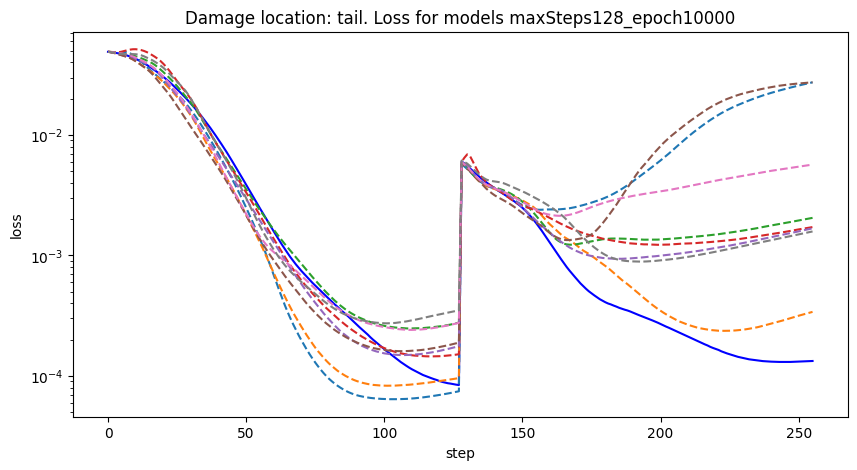

In [81]:
# Plot in the same axis as all the .csv files in the /test_losses folder.
# The 1st column of each csv file is the step, the 2nd column is the loss, but the columns are not named in the file.
damage_location = 'tail'
file_ending = f'maxSteps{global_params["MAX_STEPS"]}_epoch{training_params["n_epoch"]}.csv'
file_names = [t for t in os.listdir(f'damage_losses/{damage_location}') if t.endswith(file_ending)]
print(file_names)
test_losses = [pd.read_csv(os.path.join(f'damage_losses/{damage_location}', t)) for t in file_names]

# plot the test losses
plt.figure(figsize=(10,5))
for i, t in enumerate(test_losses):
    if 'EnergyCA' in file_names[i]:
        plt.plot(t['step'], t['loss'],'--', label=file_names[i].split('_')[:-1])
    else:
        plt.plot(t['step'], t['loss'],'b-', label=file_names[i].split('_')[:-1])
plt.xlabel('step')
plt.ylabel('loss')
plt.yscale('log')
plt.title(f'Damage location: {damage_location}. Loss for models ' + file_ending.split('.')[0])
#plt.legend()
plt.show()

